# Here is an example for PINN-based tomography

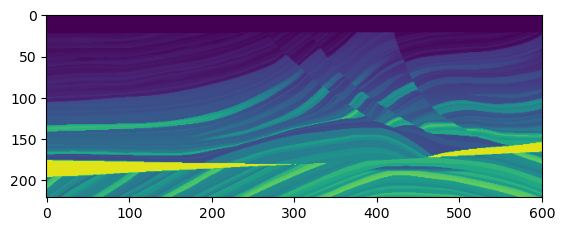

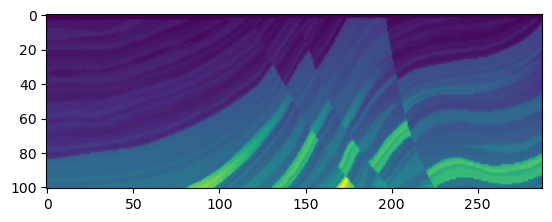

In [1]:
#conda activate eqp (eqpolarity or eqpicking environment)
# to be changed
# Mac Pro Base Env
#
# Or
# python 3.12.7
# pykonal: 0.4.1
# scikit-learn: 1.5.1
# scipy: 1.13.1
# torch: 2.6.0
# torchvision: 0.21.0

# !pip install git+https://github.com/aaspip/pyekfmm

import os
import numpy as np 
from scipy import interpolate
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

# import library
def numerical_traveltime2d_pykonal(vel, nx, nz, ns, xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z):
    
    import pykonal

    T_data_surf = np.zeros((nz,nx,ns))

    for i in range(ns):

        solver = pykonal.EikonalSolver(coord_sys="cartesian")
        solver.velocity.min_coords = zmin, xmin, zmin
        solver.velocity.node_intervals = deltaz, deltax, deltaz
        solver.velocity.npts = nz, nx, 1
        solver.velocity.values = vel.reshape(nz,nx,1)

        src_idx = id_sou_z[i], id_sou_x[i], 0
        
        solver.traveltime.values[src_idx] = 0
        solver.unknown[src_idx] = False
        solver.trial.push(*src_idx)

        solver.solve()

        teik = solver.traveltime.values

        T_data_surf[:,:,i] = teik[:,:,0]
    
    return T_data_surf

def numerical_traveltime2d_pyekfmm(vel, nx, nz, ns, xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z):
    '''
    INPUT
    vel: 2D velocity (zx)

    OUTPUT
    T_data_surf: output traveltime fields of different sources (zx)
    '''
    
    import pyekfmm as fmm
    
    T_data_surf = np.zeros((nz,nx,ns))
    
    velxz=np.transpose(vel,[1,0]) #put X the first dimension, always for pyefkmm
                       
    for i in range(ns):         
        t=fmm.eikonal(velxz,xyz=np.array([xmin+deltax*id_sou_x[i],0,zmin+deltaz*id_sou_z[i]]),ax=[xmin,deltax,nx],ay=[0,0.05,1],az=[zmin,deltaz,nz],order=2);
        teik=t.reshape(nx,nz,order='F');#first axis (vertical) is x, second is z
        T_data_surf[:,:,i] = np.transpose(teik[:,:],[1,0]) #from XZ to ZX
    
    return T_data_surf
    
## define the calculation space
zmin = 0; zmax = 1; deltaz = 0.01;
xmin = 0.; xmax = 8.6; deltax = 0.03;

z = np.arange(zmin,zmax+deltaz,deltaz)
nz = z.size

x = np.arange(xmin,xmax+deltax,deltax)
nx = x.size

vel = np.fromfile('smalldata/marmousi.bin', np.float32).reshape(221, 601)
plt.imshow(vel);plt.show()

x1 = np.linspace(0, 5, 601)
z1 = np.linspace(0, 1, 221) 
x2 = np.linspace(0.25, 5, len(x))
z2 = np.linspace(0.09, 0.55, len(z)) 
f = interpolate.interp2d (x1, z1, vel)
vel = f(x2, z2)

#The space is
# Z: 0.25-5.0 km, nz=101
# X: 0.09-0.55 km, nx=288

plt.imshow(vel);plt.show()

# plt.imshow(np.transpose(vel,[1,0])) #view velocity in XZ


In [2]:
id_sou_x=np.array([  0,  40,  80, 120, 160, 200, 240, 280]);
id_sou_z=np.array([5, 5, 5, 5, 5, 5, 5, 5]);

id_rec_x=np.array([  0,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])
id_rec_z=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

T_data0 = numerical_traveltime2d_pykonal(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)
T_data = numerical_traveltime2d_pyekfmm(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)

T_data.shape


(101, 288, 8)

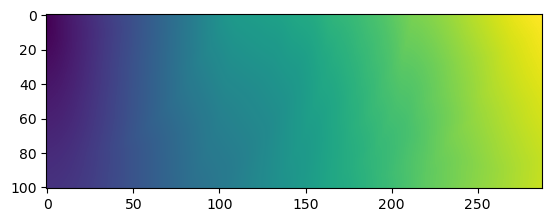

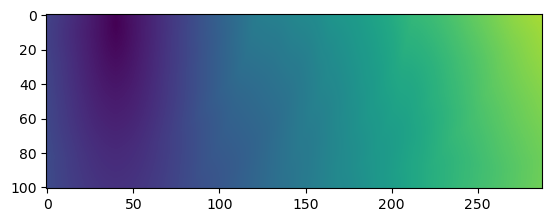

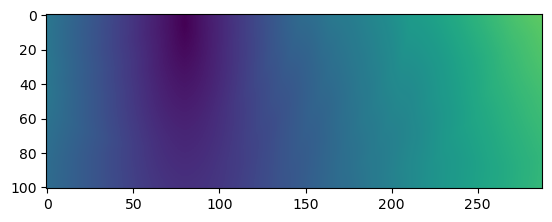

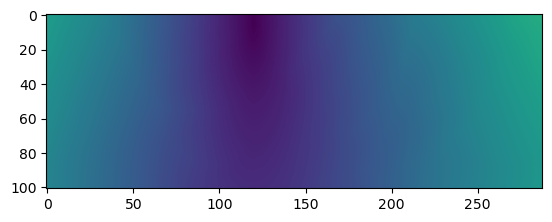

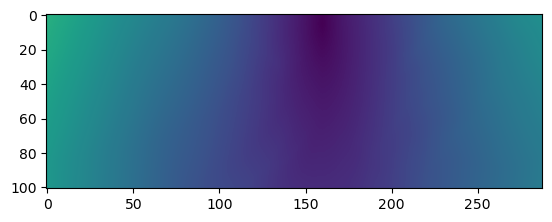

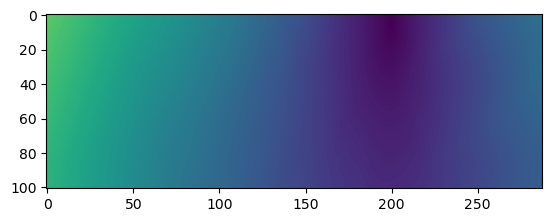

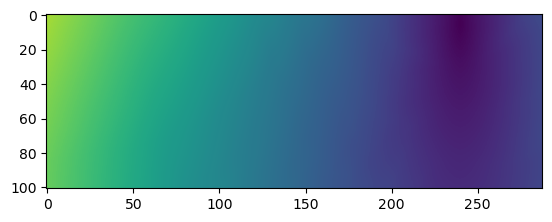

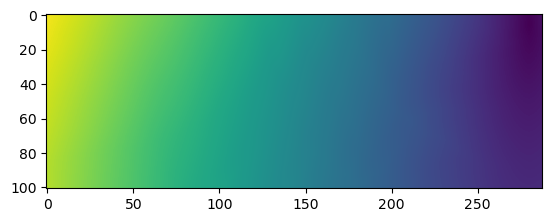

In [3]:
for ii in range(T_data.shape[2]):
    plt.imshow(T_data0[:,:,ii],clim=[0,3.5])
    plt.show()

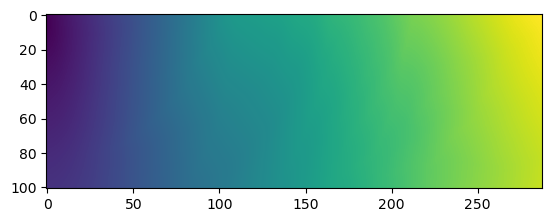

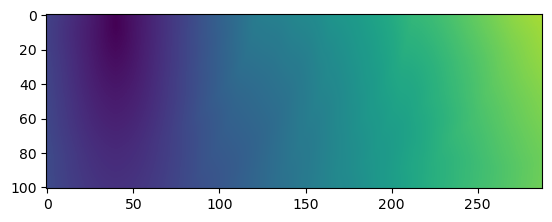

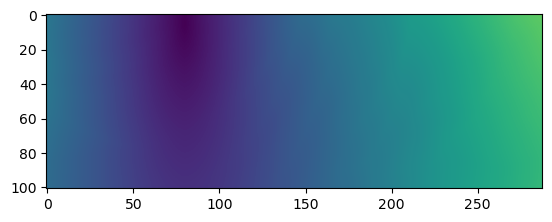

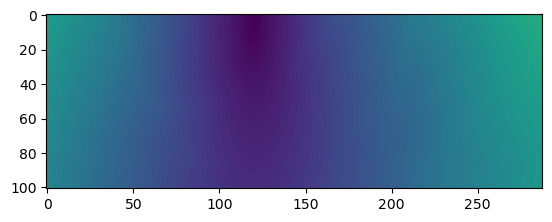

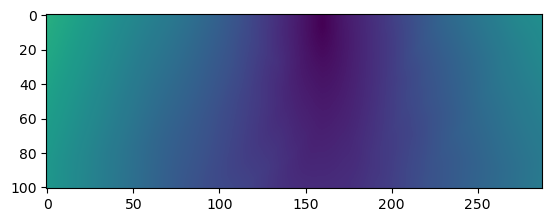

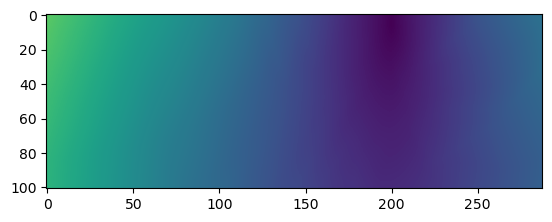

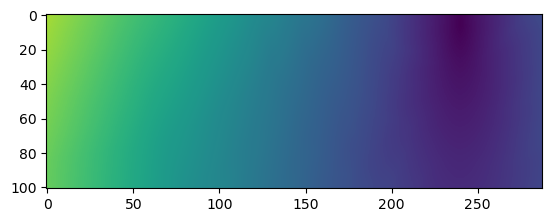

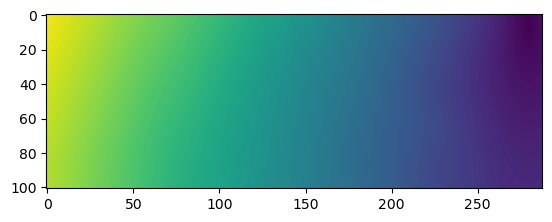

In [4]:
for ii in range(T_data.shape[2]):
    plt.imshow(T_data[:,:,ii],clim=[0,3.5])
    plt.show()

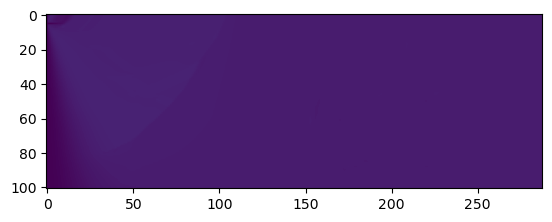

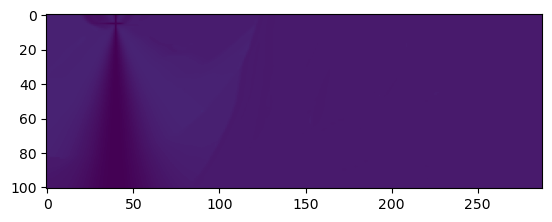

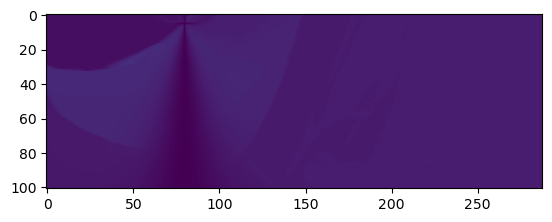

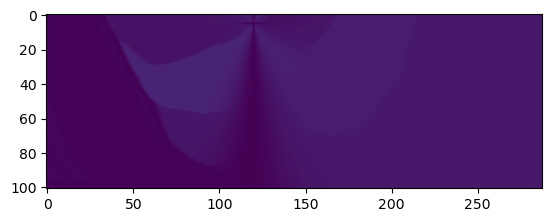

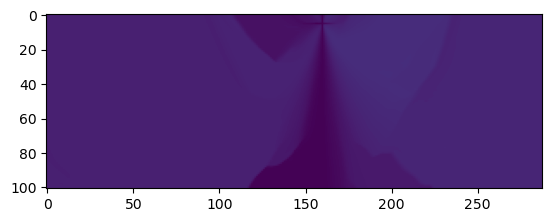

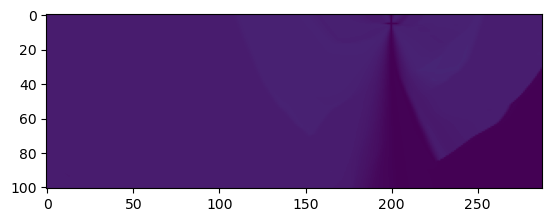

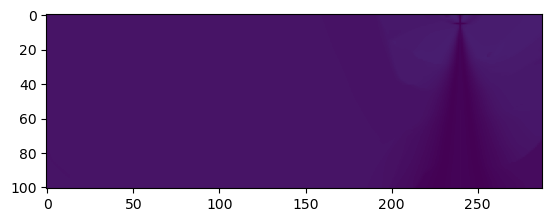

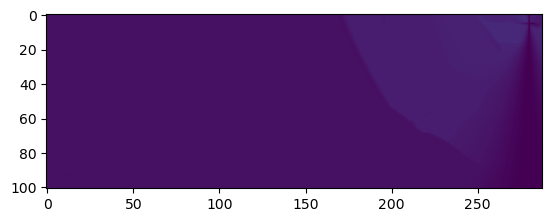

In [5]:
for ii in range(T_data.shape[2]):
    plt.imshow(np.abs(T_data0[:,:,ii]-T_data[:,:,ii]),clim=np.array([0,3.5])*0.01)
    plt.show()

In [6]:
## For this Traveltime prediction problem
## X is four-element vector (x,z source, and x,z receiver)
# Y is the traveltime corresponding to each source and receiver pair
# There are 120 traveltime samples, X: 120*4; Y: 120

import torch

Td_nn = np.zeros_like(T_data)
taudx_nn = np.zeros_like(T_data)

Ti_data = np.zeros((len(x[id_rec_x])*len(id_sou_x)))
xri = np.tile(x[id_rec_x], len(id_sou_x))
zri = np.tile(z[id_rec_z], len(id_sou_z))
xsi = np.repeat(x[id_sou_x], len(id_rec_x))
zsi = np.repeat(z[id_sou_z], len(id_rec_z))

for i in range(len(id_sou_x)):
    Ti_data[i*len(x[id_rec_x]):(i+1)*len(x[id_rec_x])] = T_data[id_rec_z,id_rec_x,i]

rand_idx = np.random.permutation(np.arange(len(Ti_data)))

X_ori = np.vstack((xri, zri, xsi, zsi)).T
y_ori = Ti_data

X_all = X_ori[rand_idx,:]
y_all = y_ori[rand_idx]

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

X_ori = torch.from_numpy(X_ori).float()

all_dataset = torch.utils.data.TensorDataset(X_all, y_all)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
all_loader = torch.utils.data.DataLoader(all_dataset, batch_size=16, shuffle=True)


In [7]:
from argparse import ArgumentParser
parser = ArgumentParser(description="Surface tomography example 1")
args = parser.parse_args([])

args.use_wandb='n'

dict_args = vars(args)
print(dict_args)

# Change these lines for the wandb setup
if args.use_wandb=='y':
    wandb.init(project=args.project_name)
    wandb.run.log_code(".")
    wandb_dir = wandb.run.dir
else:
    args.save_folder='../saves/saves_fullnss2d'
    from pathlib import Path
    Path(args.save_folder).mkdir(parents=True, exist_ok=True)
    wandb_dir = args.save_folder


# ## Define arguments

# In[2]:


args.scale_factor=2 
args.until_cmb='y' 
args.num_epochs=500
args.seed=1234 
args.learning_rate=1e-3 
args.rescale_plot='y' 
args.initial_velocity=3 
args.zid_source=5 
args.zid_receiver=0 
args.data_type='full' 
args.irregular_grid='y' 
args.num_layers=12 
args.model_type='marmousi' 
args.v_multiplier=3 
args.factorization_type='additive' 
args.tau_act='tanh' 
args.tau_multiplier=1 
args.max_offset=8.6 
args.max_depth=1 
args.vertical_spacing=0.01 
args.lateral_spacing=0.03 
args.num_neurons=24 
args.causality_factor=.5 

args.causality_weight='type_0' 
args.reduce_after=50 
args.field_synthetic='n' 
args.event_factor=0.9 
args.station_factor=0.1 
args.residual_network='y' 
args.empty_middle='n' 
args.regular_station='y' 
args.rec_spacing=20 
args.sou_spacing=40
args.exp_function='n'
args.velocity_loss='n'
args.regularization_type='None'
args.activation='elu'
args.initialization='varianceScaling'
dict_args = vars(args)


{'use_wandb': 'n'}


In [8]:
print('X_ori.shape',X_ori.shape)
print('y_ori.shape',y_ori.shape)
print('T_data.shape',T_data.shape)
print('Ti_data.shape',Ti_data.shape)
print('id_rec_x.shape',id_rec_x.shape)
print('id_sou_x.shape',id_sou_x.shape)

X_ori.shape torch.Size([120, 4])
y_ori.shape (120,)
T_data.shape (101, 288, 8)
Ti_data.shape (120,)
id_rec_x.shape (15,)
id_sou_x.shape (8,)


In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Linear

def activation(act_fun='leakyrelu'):

    if isinstance(act_fun, str):
        if act_fun == 'leakyrelu':
            return nn.LeakyReLU(0.2, inplace='y')
        elif act_fun == 'elu':
            return nn.ELU()
        elif act_fun == 'relu':
            return nn.ReLU()
        elif act_fun == 'tanh':
            return nn.Tanh()
        elif act_fun == 'swish':
            return Swish()
        else:
            raise ValueError(f'{act_fun} is not an activation function...')
    else:
        return act_fun

def layer(lay='linear'):
    if isinstance(lay, str):
        if lay == 'linear':
            return lambda x,y: nn.Linear(x, y)
        
        elif lay == 'adaptive':
            return lambda x,y: AdaptiveLinear(x,y,
                                              adaptive_rate=0.1,
                                              adaptive_rate_scaler=10.)
        else:
            raise ValueError(f'{lay} is not a layer type...')
    else:
        return lay

class ResidualNetwork(torch.nn.Module):
    def __init__(self, num_input, num_output, num_layers=10, num_neurons=10,
                 lay='linear', act='relu', last_act=None, last_multiplier=1, last_abs=False):
        
            super(ResidualNetwork, self).__init__()
            
            self.act = activation(act)
            self.last_act = activation(last_act)
            self.last_multiplier = last_multiplier
            self.last_abs = last_abs

            # Input Structure
            self.fc0  = Linear(num_input,num_neurons)
            self.fc1  = Linear(num_neurons,num_neurons)

            # Resnet Block
            self.rn_fc1 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])
            self.rn_fc2 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])
            self.rn_fc3 = torch.nn.ModuleList([Linear(num_neurons, num_neurons) for i in range(num_layers)])

            # Output structure
            self.fc8  = Linear(num_neurons,num_neurons)
            self.fc9  = Linear(num_neurons,num_output)

    def forward(self,x):
        x = self.act(self.fc0(x))
        x = self.act(self.fc1(x))
        for j in range(len(self.rn_fc1)):
            x0 = x
            x  = self.act(self.rn_fc1[j](x))
            x  = self.act(self.rn_fc3[j](x)+self.rn_fc2[j](x0))

        x = self.act(self.fc8(x))
        x = self.fc9(x)
        
        if self.last_act is not None:
            x = self.last_act(x)
        elif self.last_abs:
            x = torch.abs(x)
        x = x * self.last_multiplier
        return x

class FullyConnectedNetwork(nn.Module):
    
    def __init__(self, num_input, num_output, n_hidden=[16, 32],
                 lay='linear', act='tanh', last_act=None, last_multiplier=1):
        super(FullyConnectedNetwork, self).__init__()
        self.lay = lay
        self.act = act
        self.last_multiplier = last_multiplier
        self.last_act = last_act

        act = activation(act)
        lay = layer(lay)
        if last_act == 'sigmoid':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.Sigmoid()
            )
        elif last_act == 'relu':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.ReLU()
            )
        elif last_act == 'tanh':
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output),
                nn.Tanh()
            )
        else:
            self.model = nn.Sequential(
                nn.Sequential(lay(num_input, n_hidden[0]), act),
                *[nn.Sequential(lay(n_hidden[i], n_hidden[i + 1]),act) for i in range(len(n_hidden) - 1)],
                lay(n_hidden[-1], num_output)
            )

    def forward(self, x):
        x = self.model(x) #/ (1-0.9999)
        return x*self.last_multiplier
    
class VelocityNetwork(torch.nn.Module):
    def __init__(self, base_model, v_well=1, X_well=None):
        
            super(VelocityNetwork, self).__init__()
            
            self.model = base_model
            self.v_well = v_well
            self.X_well = X_well
            
            if self.X_well is not None:
                self.x_well = X_well[:,0]
                self.y_well = X_well[:,1]
            
    def _well_operator(self, x):
#         x_op, y_op = 1, 1
        
#         for i in range(len(self.x_well)):
#             x_op *= (x[:,0] - self.x_well[i]) 
#         for i in range(len(self.y_well)):
#             y_op *= (x[:,1] - self.y_well[i])
        
#         return nn.Tanh()(x_op + y_op)

        return torch.exp(-0.05*x[:,2]).view(-1,1)

    def forward(self,x,v_well=1):
        
        if self.X_well is not None:
            x = v_well.view(-1,1) + self.model(x) #* self._well_operator(x)
        else:
            x = self.model(x)
        return x
    
import pytorch_lightning as pl
import torchvision
import torch.nn.functional as F

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 128 => 64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 64 => 32
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 32 => 16
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16 => 4
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16 => 4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            # nn.Linear(2*16**2*c_hid, latent_dim)
            nn.Linear(2*4**2*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)
    
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            # nn.Linear(latent_dim, 2*16**2*c_hid),
            nn.Linear(latent_dim, 2*4**2*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4 => 8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8 => 16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 16 => 32
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 32 => 64
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 64 => 128
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x
    
class AutoEncoder(pl.LightningModule):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 128, 
                 height: int = 128):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters() 
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    
    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=20, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)                             
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)
    
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)
        
    def encode(self, x):
        """
        The forward function takes in an image and returns the latent variables
        """
        z = self.encoder(x)
        # x_hat = self.decoder(z)
        return z
    
    def encode(self, z):
        """
        The forward function takes in a latent variables and returns the reconstructed image
        """
        x_hat = self.decoder(z)
        return x_hat
    
class GenerateCallback(pl.Callback):
    
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)
        
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

reduce_after=50
data_layers=8
data_neurons=16
zid_receiver=0
field_synthetic='n'
sx=np.array([0. , 1.2, 2.4, 3.6, 4.8, 6. , 7.2, 8.4])
sz=np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
if 0:
    torch.manual_seed(8888)
    model = FullyConnectedNetwork(4, 1, n_hidden=[data_neurons]*data_layers, act='elu') #traveltime model
    # optimizer = torch.optim.Adam(model.parameters(), lr=5e-4) # best
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(5*args.reduce_after), verbose=True)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(4*reduce_after), verbose=True)
    criterion = torch.nn.MSELoss()
    model.train()
    loss_data = []
    for epoch in range(int(1e3)):
        total_loss = 0.
        model.train()
        loss = 0
        for x_i, y_i in all_loader:
            optimizer.zero_grad()
            yest = model(x_i).view(-1)
            loss = criterion(yest, y_i)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 50 == 0 and epoch > 0:
            print(f'Epoch: {epoch}, Loss: {total_loss / X_all[:,0].detach().numpy().size}')
        mean_loss = total_loss / X_all[:,0].detach().numpy().size
        # wandb.log({"data_loss": mean_loss})
        scheduler.step(mean_loss)
        loss_data.append(mean_loss)

    Td_nn = np.zeros_like(T_data)
    
    if field_synthetic=='y':
        X_all = [np.tile(x[id_top_x], len(sx)), np.tile(z[id_top_z], len(sz)), 
                 np.repeat(x[id_sou_x], len(x[id_top_x])), 
                 np.repeat(z[id_sou_z], len(z[id_top_z]))]
    else:
        X_all = [np.tile(x, len(sx)), np.tile(z[zid_receiver]*np.ones_like(x), len(sz)), 
                 np.repeat(x[id_sou_x], len(x)), 
                 np.repeat(z[id_sou_z], len(x))]

    model.eval()
    Td_pred = model(torch.FloatTensor(X_all).T)

    for i in range(len(id_sou_x)):
        Td_nn[:,:,i] = Td_pred[i*len(x):(i+1)*len(x)].detach().numpy().reshape(-1)

    # Convergence history plot for verification
    fig = plt.figure()
    ax = plt.axes()
    ax.semilogy(loss_data)

    ax.set_xlabel('Epochs',fontsize=14)

    plt.xticks(fontsize=11)

    ax.set_ylabel('Loss',fontsize=14)
    plt.yticks(fontsize=11);
    plt.grid()
    plt.savefig(os.path.join('./', "data_loss.png"), format='png', bbox_inches="tight")

    # Save model
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_data
    }, './data.h5')



In [11]:
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=200**3, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches


def init_weights(m,init_type='xavierUniform', bias=0.1, mean=0., std=1.,):
    
    if isinstance(m, nn.Linear):
        if init_type=='xavierUniform':
            torch.nn.init.xavier_uniform_(m.weight)
        elif init_type=='xavierNormal':
            torch.nn.init.xavier_normal_(m.weight)
        elif init_type=='kaimingUniform':
            torch.nn.init.kaiming_uniform_(m.weight)
        elif init_type=='normal':
            m.weight.data.normal_(mean, std)
        elif init_type=='uniform':
            m.weight.data.uniform_(-2.0, 15.0)
        m.bias.data.fill_(bias)

# Network
lay = 'linear'
ini = args.initialization
bias = 2
mean = 0.5
std = 1
opttype = 'adam'
lr = args.learning_rate


# tau_model = FullyConnectedNetwork(3, 1, n_hidden=[data_neurons]*data_layers, act='elu') #traveltime model
tau_model = ResidualNetwork(3, 1, num_neurons=args.num_neurons, num_layers=args.num_layers, act=args.activation, lay=lay, last_multiplier=args.tau_multiplier)

# v_model = FullyConnectedNetwork(2, 1, n_hidden=[data_neurons]*data_layers, act='elu')  #velocity model
v_model = ResidualNetwork(2, 1, num_neurons=args.num_neurons//2, act='relu', last_act='relu', num_layers=args.num_layers, lay=lay, last_multiplier=args.v_multiplier)
v_model.apply(lambda m: init_weights(m, init_type=ini, bias=bias, mean=mean, std=std))

def evaluate_tau(tau_model, grid_loader):
    tau_model.eval()
    
    with torch.no_grad():
        xz, s, taud, taud_dx, t0, t0_dx, t0_dz, _ = next(iter(grid_loader))
        xz.requires_grad = True
        xzs = torch.hstack((xz, s.view(-1,1)))
        T = tau_model(xzs)
        
    return T

def evaluate_velocity(v_model, grid_loader):
    v_model.eval()
    
    # Prepare input
    xz, s, taud, taud_dx, t0, t0_dx, t0_dz, _ = next(iter(grid_loader))
    xz.requires_grad = True
    xzs = torch.hstack((xz, s.view(-1,1)))

    # Compute v
    v = v_model(xzs[:,:2]).view(-1)

    return v

from torch.utils.data import TensorDataset, DataLoader
def create_dataloader2d(input_vec, sx, sz, batch_size=200**3, shuffle=True, 
                      device='cuda', fast_loader='n', perm_id=None):
    
    XZ = torch.from_numpy(np.vstack((input_vec[0], input_vec[1])).T).float().to(device)
    S = torch.from_numpy(input_vec[2]).float().to(device)
    
    taud = torch.from_numpy(input_vec[3]).float().to(device)
    taud_dx = torch.from_numpy(input_vec[4]).float().to(device)

    tana = torch.from_numpy(input_vec[5]).float().to(device)
    tana_dx = torch.from_numpy(input_vec[6]).float().to(device)
    tana_dz = torch.from_numpy(input_vec[7]).float().to(device)
    
    index = torch.arange(input_vec[0].size)
    
    if perm_id is not None:
        dataset = TensorDataset(XZ[perm_id], S[perm_id], taud[perm_id], 
                                taud_dx[perm_id], tana[perm_id], tana_dx[perm_id], 
                                tana_dz[perm_id], index[perm_id])
    else:
        dataset = TensorDataset(XZ, S, taud, taud_dx, tana, tana_dx, tana_dz, index)
    
    if fast_loader:
        data_loader = FastTensorDataLoader(XZ, S, taud, taud_dx, tana, 
                                           tana_dx, tana_dz, index, 
                                           batch_size=batch_size, shuffle=shuffle)
    else:
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # initial condition
    ic = torch.tensor(np.array([sx, sz]), dtype=torch.float).to(device)

    return data_loader, ic.T





In [12]:
args.residual_network

'y'

In [13]:
args.activation

'elu'

In [14]:

Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')
SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

velmodel = np.repeat(vel[...,np.newaxis],sx.size,axis=2)
vs = velmodel[np.round(SZ/deltaz).astype(int),np.round(SX/deltax).astype(int),0]


T0 = np.sqrt((Z-SZ)**2 + (X-SX)**2)/vs;
px0 = np.divide(X-SX, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)
pz0 = np.divide(Z-SZ, T0*vs**2, out=np.zeros_like(T0), where=T0!=0)

Td_hc = np.zeros_like(T0)
T0_hc = np.zeros_like(T0)
taud_hc = np.zeros_like(T0)
taudx_hc = np.zeros_like(T0)

for i in range(len(id_sou_x)):
    T0_hc[:,:,i] = np.tile(T0[0,:,i], nz).reshape(nz,nx)
    Td_hc[:,:,i] = np.tile(T_data[0,:,i], nz).reshape(nz,nx)
    taud_hc[:,:,i] = Td_hc[:,:,i] - T0_hc[:,:,i]
    taudx_hc[:,:,i] = np.gradient(taud_hc.reshape(nz,nx,len(id_sou_x))[:,:,i], deltax, axis=1)

taud = taud_hc.reshape(-1,1)
taudx = taudx_hc.reshape(-1,1)
index = torch.arange(T0.size)

input_wsrc = [X, Z, SX, taud, taudx, T0, px0, pz0, index]

npoints = int(X.size)
ipermute = np.random.permutation(np.arange(X.size))[:npoints]


In [15]:
# Compute traveltime with randomly initialized network
pde_loader, ic = create_dataloader2d([i.ravel() for i in input_wsrc], sx, np.ones_like(sx)*sz.reshape(-1,),
                                   shuffle=False, fast_loader=True, perm_id=ipermute, device='cpu')

device='cpu'
v_init = evaluate_velocity(v_model, pde_loader)
tau_init = evaluate_tau(tau_model, pde_loader)


In [16]:
xz, s, taud, taud_dx, t0, t0_dx, t0_dz, _ = next(iter(pde_loader))

In [17]:
v_model

ResidualNetwork(
  (act): ReLU()
  (last_act): ReLU()
  (fc0): Linear(in_features=2, out_features=12, bias=True)
  (fc1): Linear(in_features=12, out_features=12, bias=True)
  (rn_fc1): ModuleList(
    (0-11): 12 x Linear(in_features=12, out_features=12, bias=True)
  )
  (rn_fc2): ModuleList(
    (0-11): 12 x Linear(in_features=12, out_features=12, bias=True)
  )
  (rn_fc3): ModuleList(
    (0-11): 12 x Linear(in_features=12, out_features=12, bias=True)
  )
  (fc8): Linear(in_features=12, out_features=12, bias=True)
  (fc9): Linear(in_features=12, out_features=1, bias=True)
)

In [18]:
tau_model

ResidualNetwork(
  (act): ELU(alpha=1.0)
  (fc0): Linear(in_features=3, out_features=24, bias=True)
  (fc1): Linear(in_features=24, out_features=24, bias=True)
  (rn_fc1): ModuleList(
    (0-11): 12 x Linear(in_features=24, out_features=24, bias=True)
  )
  (rn_fc2): ModuleList(
    (0-11): 12 x Linear(in_features=24, out_features=24, bias=True)
  )
  (rn_fc3): ModuleList(
    (0-11): 12 x Linear(in_features=24, out_features=24, bias=True)
  )
  (fc8): Linear(in_features=24, out_features=24, bias=True)
  (fc9): Linear(in_features=24, out_features=1, bias=True)
)

In [19]:
# exp_factor=0
def train(input_wosrc, sx, sz,
          tau_model, v_model, optimizer, epoch,
          batch_size, vscaler, scheduler, fast_loader, device, args):
    tau_model.train()
    v_model.train()
    loss = []
    
    # Create dataloader
    weights = torch.Tensor(torch.ones(len(input_wosrc[0]))).to(device)
    data_loader, ic = create_dataloader2d(input_wosrc, sx, sz, batch_size, shuffle='y', device=device, fast_loader=fast_loader, perm_id=None)
        
    for xz, s, taud, taud_dx, t0, t0_dx, t0_dz, index in data_loader:
        
        # Number of source
        num_sou = len(ic[:,0])

        xz.requires_grad = True

        # Input for the velocity network
        xzic = torch.cat([xz, ic])

        # Source X's location
        sic = torch.cat([s, ic[:,0]])

        # Input for the data network
        xzsic = torch.hstack((xzic, sic.view(-1,1)))

        # Compute T
        tau = tau_model(xzsic).view(-1)

        # Compute v
        v = v_model(xzsic[:, :2]).view(-1)

        # Gradients
        gradient = torch.autograd.grad(tau, xzsic, torch.ones_like(tau), create_graph=True)[0]
        
        tau_dx = gradient[:, 0]
        tau_dz = gradient[:, 1]
    
        # Loss function based on the factored isotropic eikonal equation
        if args['exp_function']=='y':
            rec_op = (1-torch.exp((xz[:,1])**args['exp_factor']))

            # Initialize output tensor with desired value
            rec_op_dz = torch.full_like(xz[:,1], fill_value=0.)

            # Zero mask
            mask = (xz[:,1] != 0)

            rec_op_dz[mask] = (-args['exp_factor']*torch.exp((xz[:,1][mask])**args['exp_factor'])/(xz[:,1][mask]**(1-args['exp_factor'])))
        else:
            rec_op = xz[:,1]
            rec_op_dz = 1
                
        if args['factorization_type']=='multiplicative':
            T_dx = (rec_op*tau_dx[:-num_sou] + taud_dx)*t0 + (rec_op*tau[:-num_sou] + taud)*t0_dx
            T_dz = (rec_op*tau_dz[:-num_sou] + rec_op_dz*tau[:-num_sou])*t0 + (rec_op*tau[:-num_sou] + taud)*t0_dz
        else:
            T_dx = rec_op*tau_dx[:-num_sou] + taud_dx + t0_dx
            T_dz = rec_op*tau_dz[:-num_sou] + rec_op_dz*tau[:-num_sou] + t0_dz
        
        pde_lhs = (T_dx**2 + T_dz**2) * vscaler

        if args['velocity_loss']=='y':
            pde = torch.sqrt(1/pde_lhs) - v[:-num_sou]
        else:
            pde = pde_lhs - vscaler / (v[:-num_sou] ** 2)
        
        # No causality
        if args['causality_weight']=='type_0':
            wl2=1        
        # Stationary causality
        elif args['causality_weight']=='type_1':
            wl2 = torch.exp(-args['causality_factor']*torch.sqrt((xz[:,0]-s)**2+(xz[:,1]-z[args['zid_source']])**2))
        # Anti-causal causal non-stationary
        elif args['causality_weight']=='type_2':
            delt = (1-0.01)/args['num_epochs']
            wl2 = torch.exp((-1+delt*epoch)*args['causality_factor']*torch.sqrt((xz[:,0]-s)**2+(xz[:,1]-z[args['zid_source']])**2))
        # Anti-causal
        elif args['causality_weight']=='type_3':
            wl2 = 1.05*(1-torch.exp(-args['causality_factor']*torch.sqrt((xz[:,0]-s)**2+(xz[:,1]-z[args['zid_source']])**2)))
        # Anti-causal causal non-stationary
        elif args['causality_weight']=='type_4':
            delt = (1-0.01)/args['num_epochs']
            wl2 = torch.abs(torch.exp((-1+delt*epoch)*args['causality_factor']*torch.sqrt((xz[:,0]-s)**2+(xz[:,1]-z[args['zid_source']])**2))-1) + (1-torch.exp(torch.tensor(-5e-4*epoch)))
        
        if args['regularization_type']=='None':
            ls_pde = torch.mean(wl2*pde**2)
        elif args['regularization_type']=='isotropic-TV':
            dv_d1 = torch.autograd.grad(v, xzsic, torch.ones_like(v), create_graph=True)[0]
            # dv_d2 = torch.autograd.grad(dv_d1, xzsic, torch.ones_like(v), create_graph=True)[0]
            L1 = nn.L1Loss(reduction='sum')
            ls_pde = torch.mean(wl2*pde**2) + args['regularization_weight'] * torch.mean(torch.abs(dv_d1[:,0]) + torch.abs(dv_d1[:,1]))
        
        ls = ls_pde
        loss.append(ls.item())
        ls.backward()
        optimizer.step()
        optimizer.zero_grad()
        weights[index] = ls

        del index, xz, xzic, sic, xzsic, taud, taud_dx, t0, t0_dx, t0_dz, ls, v, tau, tau_dx, tau_dz, gradient, num_sou, T_dx, T_dz, pde_lhs, ls_pde, pde, rec_op, rec_op_dz

    mean_loss = np.sum(loss) / len(data_loader)

    return mean_loss 

    
def training_loop(input_wosrc, sx, sz,
                  tau_model, v_model, optimizer, epochs,
                  batch_size=200**3,
                  vscaler= 1., scheduler=None, fast_loader='n', device='cuda', wandb=None, args=None):

    loss_history = []

    for epoch in range(epochs):

        # Train step
        mean_loss = train(input_wosrc, sx, sz,
                  tau_model, v_model, optimizer, epoch,
                  batch_size,
                  vscaler, scheduler, fast_loader, device, args)
        if wandb is not None:
            wandb.log({"loss": mean_loss})
        loss_history.append(mean_loss)

        if epoch % 3 == 0:
            print(f'Epoch {epoch}, Loss {mean_loss:.7f}')
        
        if scheduler is not None:
            scheduler.step(mean_loss)

    return loss_history


In [20]:

X_star = [Z.reshape(-1,1), X.reshape(-1,1), SX.reshape(-1,1)] # Grid points for prediction 
isource = np.ones_like(X_star[0]).reshape(-1,).astype(bool)
perm_id = np.random.permutation(X.size-sx.size)

input_wosrc = [i.ravel()[isource.reshape(-1)][perm_id] for i in input_wsrc]

# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(list(tau_model.parameters()) + list(v_model.parameters()), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(list(tau_model.parameters()) + list(v_model.parameters()), line_search_fn="strong_wolfe")

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=args.reduce_after, verbose=True)

# for benchmark
num_epochs=1000
loss_history = \
        training_loop(
            input_wosrc, sx, np.ones_like(sx)*sz.reshape(-1,),
            tau_model, v_model, optimizer, num_epochs, 
            batch_size=Z.size//200, device=device, scheduler=scheduler, 
            fast_loader=True, args=dict_args
    )

Epoch 0, Loss 0.0093622
Epoch 3, Loss 0.0031878
Epoch 6, Loss 0.0026620
Epoch 9, Loss 0.0024654
Epoch 12, Loss 0.0023495
Epoch 15, Loss 0.0018282
Epoch 18, Loss 0.0017078
Epoch 21, Loss 0.0011032
Epoch 24, Loss 0.0009385
Epoch 27, Loss 0.0008195
Epoch 30, Loss 0.0007383
Epoch 33, Loss 0.0007074
Epoch 36, Loss 0.0006032
Epoch 39, Loss 0.0006129
Epoch 42, Loss 0.0004840
Epoch 45, Loss 0.0004545
Epoch 48, Loss 0.0003840
Epoch 51, Loss 0.0004203
Epoch 54, Loss 0.0003818
Epoch 57, Loss 0.0003778
Epoch 60, Loss 0.0004540
Epoch 63, Loss 0.0003243
Epoch 66, Loss 0.0003125
Epoch 69, Loss 0.0003213
Epoch 72, Loss 0.0003102
Epoch 75, Loss 0.0002910
Epoch 78, Loss 0.0002561
Epoch 81, Loss 0.0002643
Epoch 84, Loss 0.0002296
Epoch 87, Loss 0.0002843
Epoch 90, Loss 0.0002373
Epoch 93, Loss 0.0002625
Epoch 96, Loss 0.0002056
Epoch 99, Loss 0.0002001
Epoch 102, Loss 0.0002830
Epoch 105, Loss 0.0002368
Epoch 108, Loss 0.0002506
Epoch 111, Loss 0.0002379
Epoch 114, Loss 0.0002321
Epoch 117, Loss 0.000239

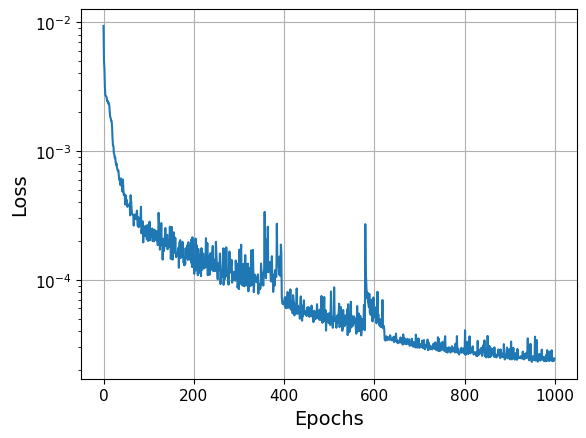

In [21]:
fig = plt.figure()
ax = plt.axes()
ax.semilogy(loss_history)
ax.set_xlabel('Epochs',fontsize=14)
plt.xticks(fontsize=11)
ax.set_ylabel('Loss',fontsize=14)
plt.yticks(fontsize=11);
plt.grid()
plt.show()
# plt.savefig(os.path.join(wandb_dir, "tomo-loss.png"), format='png', bbox_inches="tight")


In [22]:
wandb_dir

'../saves/saves_fullnss2d'

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_section(data, fig_name, data_type='km/s', vmin=None, vmax=None, 
                 cmap='terrain', save_dir='./', aspect='equal', 
                 xmin=0, xmax=1, zmin=0, zmax=1, 
                 sx=None, sz=None, rx=None, rz=None, xtop=None, ztop=None):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(data, extent=[xmin,xmax,zmax,zmin], cmap=cmap, 
                   aspect=aspect, vmin=vmin, vmax=vmax, interpolation='kaiser')

    if sx is not None:
        plt.scatter(sx, sz, 5, 'white', marker='*')

    if rx is not None:
        plt.scatter(rx, rz, 5, 'y', marker='v')

    if xtop is not None:
        plt.scatter((xtop-xtop.min()), ztop, 2, 'black', marker='o')

    plt.xlabel('Offset (km)', fontsize=14)
    plt.xticks(fontsize=11)
    plt.ylabel('Depth (km)', fontsize=14)
    plt.yticks(fontsize=11)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax)

    cbar.set_label(data_type,size=10)

    if fig_name is not None:
        plt.savefig(os.path.join(save_dir, fig_name), 
                    format='pdf', bbox_inches="tight") 


In [24]:
args.plotting_factor=1
args.depth_shift='n'

if args.exp_function=='y':
    rec_op = (1-np.exp((Z.reshape(nz,nx,len(id_sou_x))-z[args.zid_receiver])**args.exp_factor))
else:
    rec_op = Z.reshape(nz,nx,len(id_sou_x))

input_wsrc = [i.ravel() for i in input_wsrc]
pde_loader, ic = create_dataloader2d(input_wsrc, sx, np.ones_like(sx)*sz.reshape(-1,), 
                                   shuffle=False, fast_loader=True, device='cpu')
v_pred = evaluate_velocity(v_model, pde_loader)

tau_pred = evaluate_tau(tau_model, pde_loader)
tau_pred = tau_pred.detach().numpy().reshape(nz,nx,len(id_sou_x))

if args.factorization_type=='multiplicative':
    t_pred = (taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred)*T0.reshape(nz,nx,len(id_sou_x))
else:
    t_pred = taud.reshape(nz,nx,len(id_sou_x)) + rec_op*tau_pred.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))

v_init = evaluate_velocity(v_model, pde_loader)
tau_init = evaluate_tau(tau_model, pde_loader)

v_pred = v_pred.detach().numpy().reshape(nz,nx,len(id_sou_x))[:,:,0]
v_init = v_init.detach().numpy().reshape(nz,nx,len(id_sou_x))[:,:,0]
v_true = velmodel.reshape(Z.shape)[::1,:,0]

T_data = numerical_traveltime2d_pyekfmm(vel, len(x), len(z), len(id_sou_x), xmin, zmin, deltax, deltaz, id_sou_x, id_sou_z)
t_pred, T_data, T0 = t_pred*args.plotting_factor, T_data*args.plotting_factor, T0*args.plotting_factor
tau_true = T_data.reshape(nz,nx,len(id_sou_x)) - T0.reshape(nz,nx,len(id_sou_x)) - taud.reshape(nz,nx,len(id_sou_x)).detach().numpy()
tau_true = np.divide(
        tau_true, 
        rec_op, 
        out=np.ones_like(Z.reshape(nz,nx,len(id_sou_x))), 
        where=Z.reshape(nz,nx,len(id_sou_x))!=0)
T_true = rec_op*tau_true + (taud.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))).detach().numpy()


In [25]:
rec_op.shape
tau_true.shape
taud.reshape(nz,nx,len(id_sou_x))+T0.reshape(nz,nx,len(id_sou_x))
(rec_op*tau_true).shape

(101, 288, 8)

In [26]:
(taud.reshape(nz,nx,len(id_sou_x)) + T0.reshape(nz,nx,len(id_sou_x))).shape

torch.Size([101, 288, 8])

In [27]:
type(T0.reshape(nz,nx,len(id_sou_x)))

numpy.ndarray

In [28]:
print('v_pred.shape',v_pred.shape)
print('t_pred.shape',t_pred.shape)
T_data.shape

v_pred.shape (101, 288)
t_pred.shape torch.Size([101, 288, 8])


(101, 288, 8)

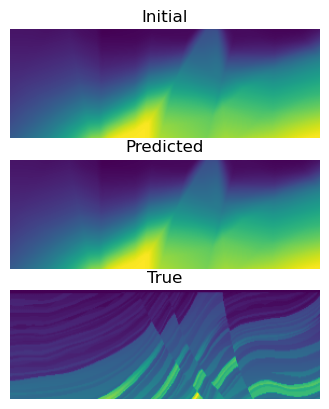

In [29]:
plt.subplot(3,1,1);
plt.imshow(v_init);plt.gca().axis('off');plt.title('Initial');
plt.subplot(3,1,2);
plt.imshow(v_pred);plt.gca().axis('off');plt.title('Predicted');
plt.subplot(3,1,3);
plt.imshow(v_true);plt.gca().axis('off');plt.title('True');

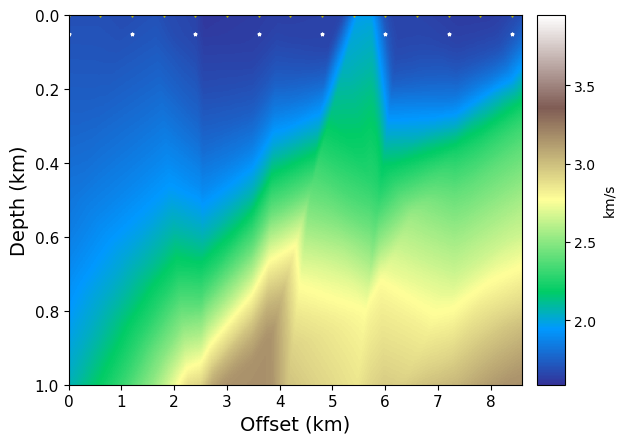

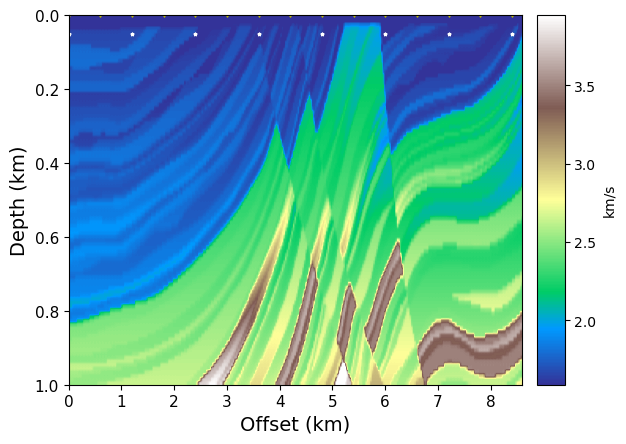

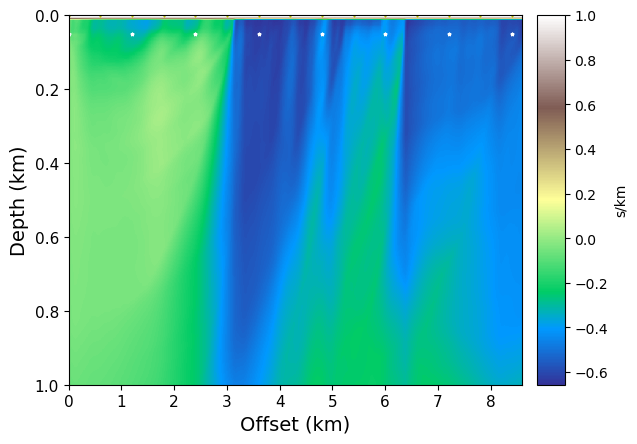

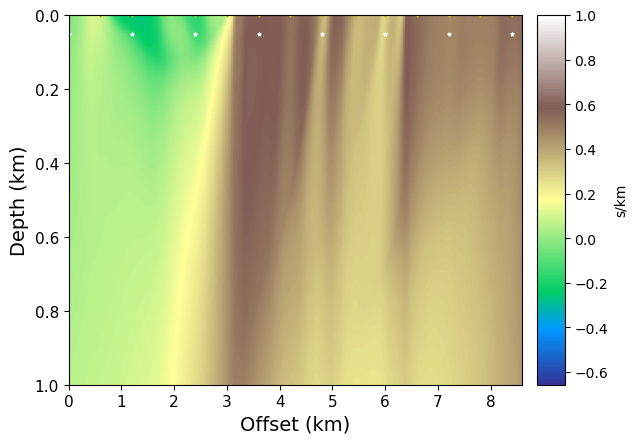

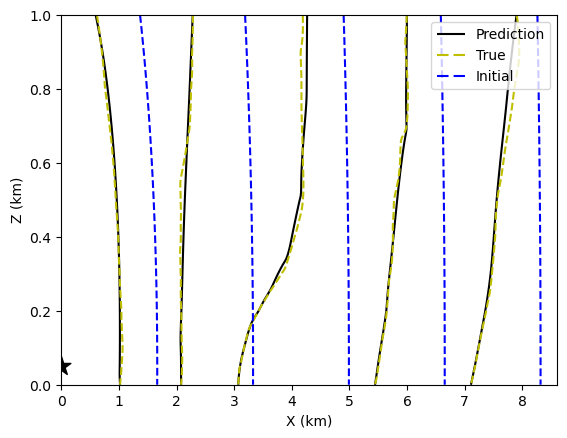

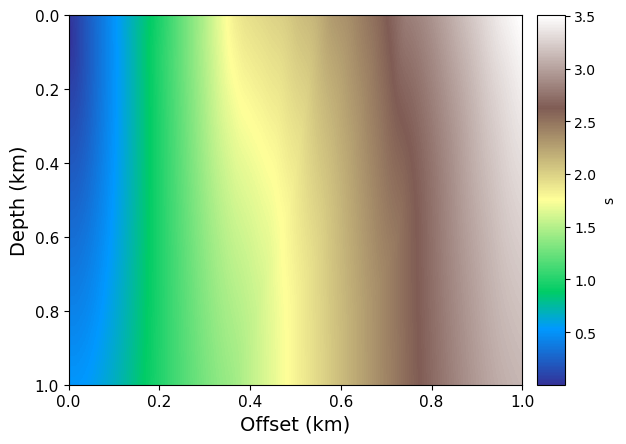

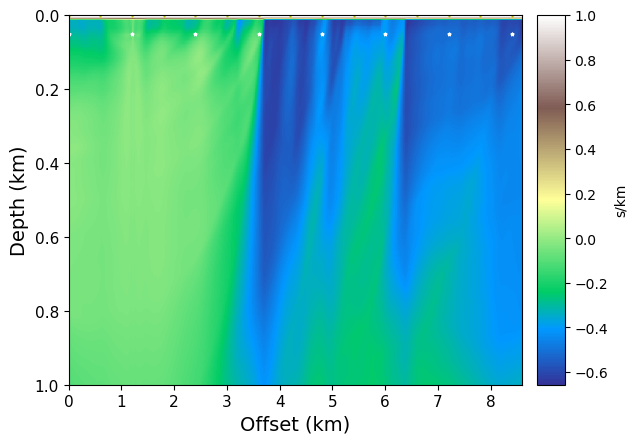

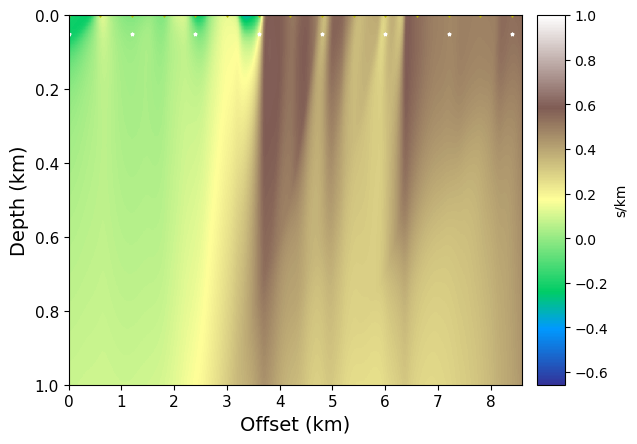

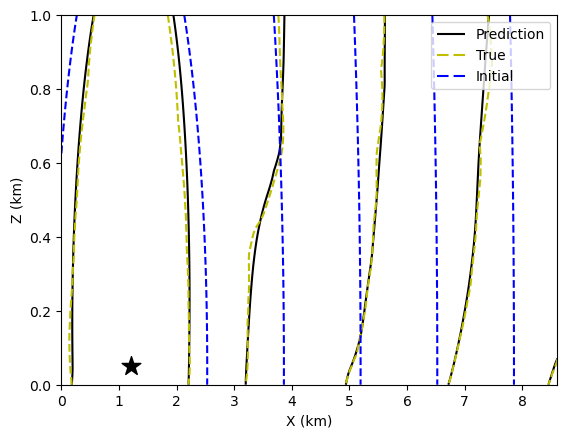

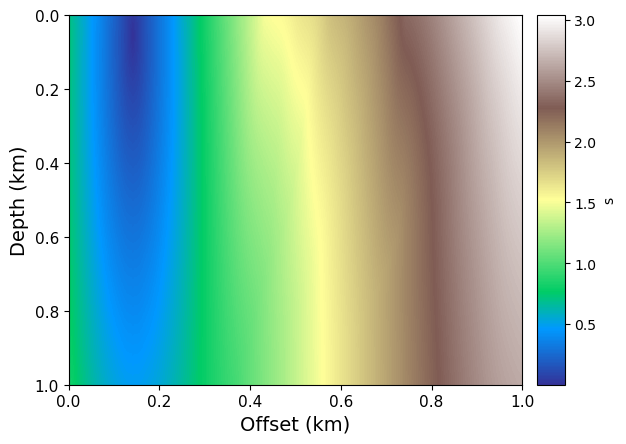

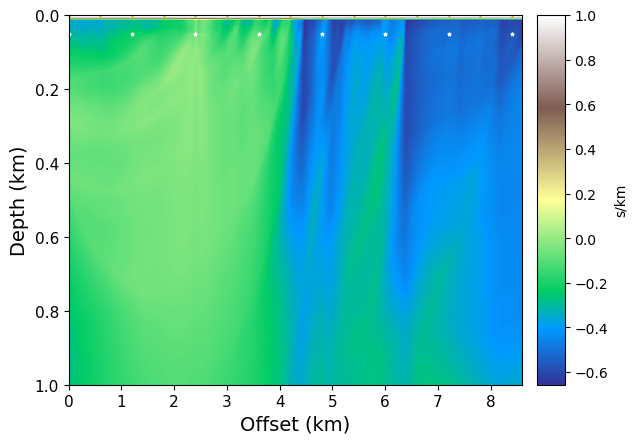

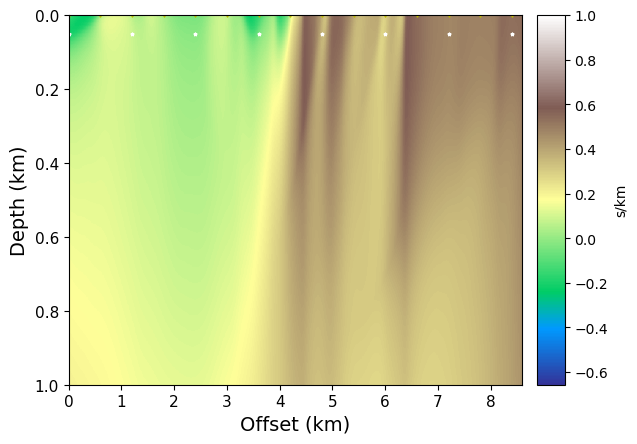

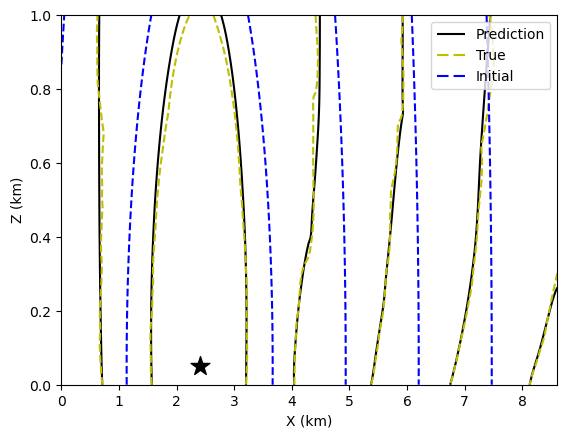

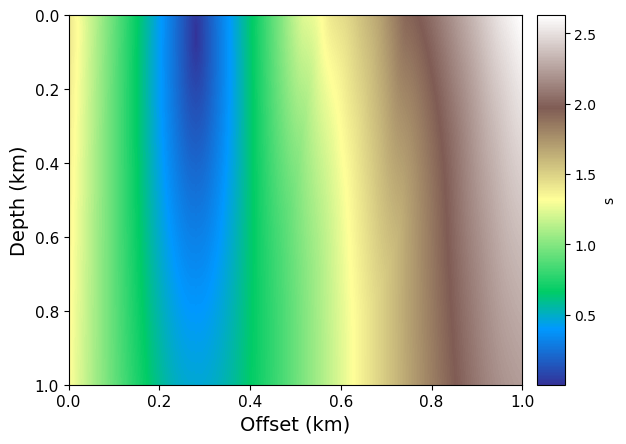

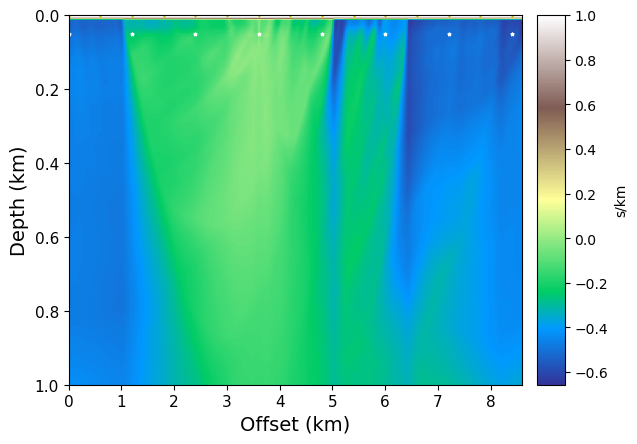

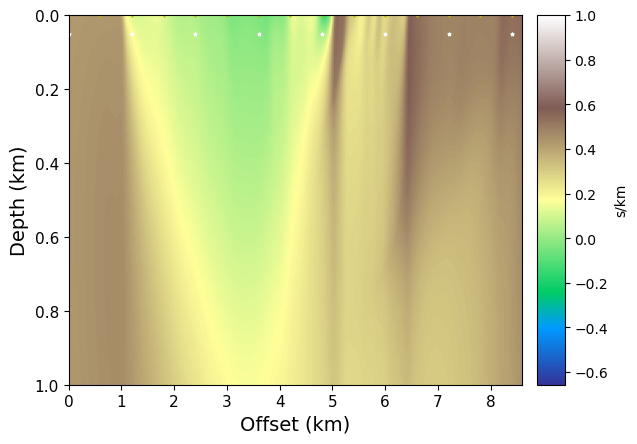

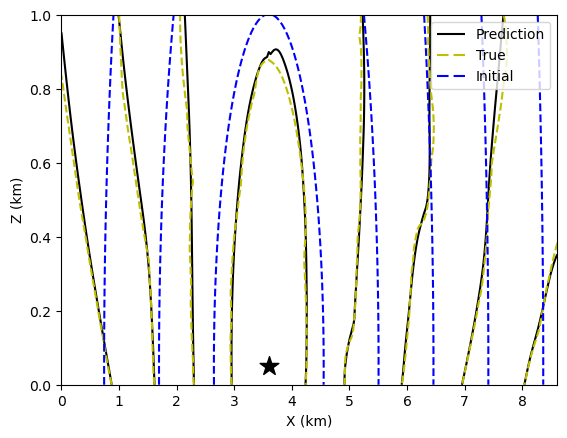

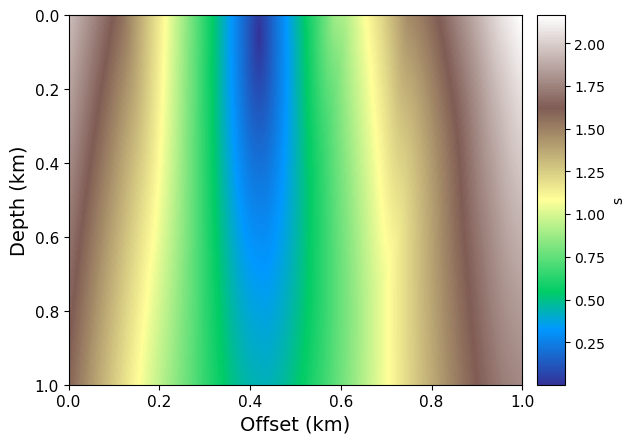

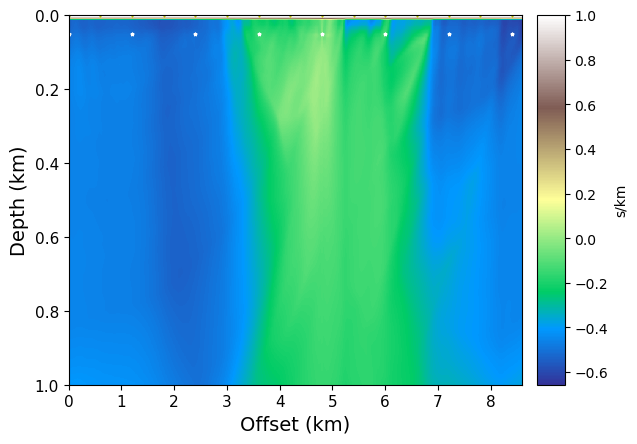

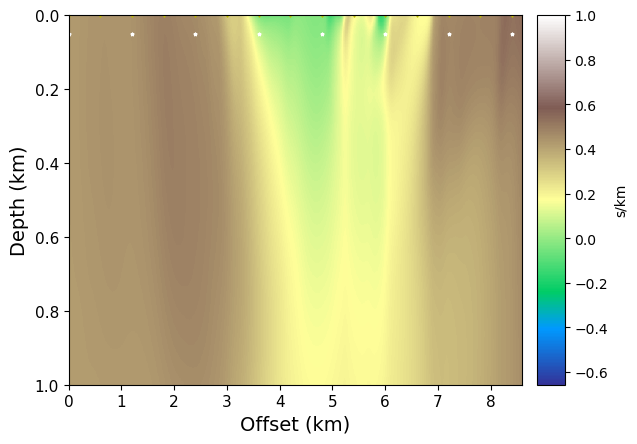

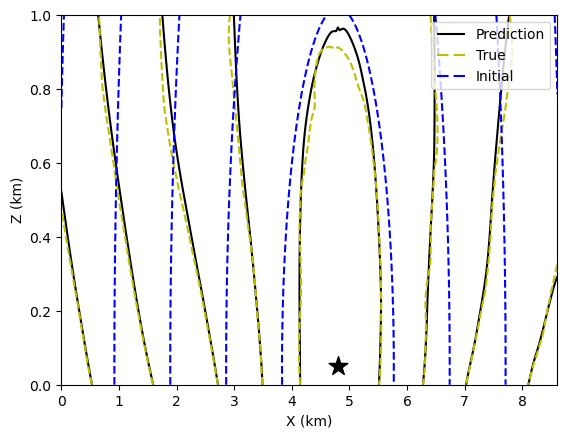

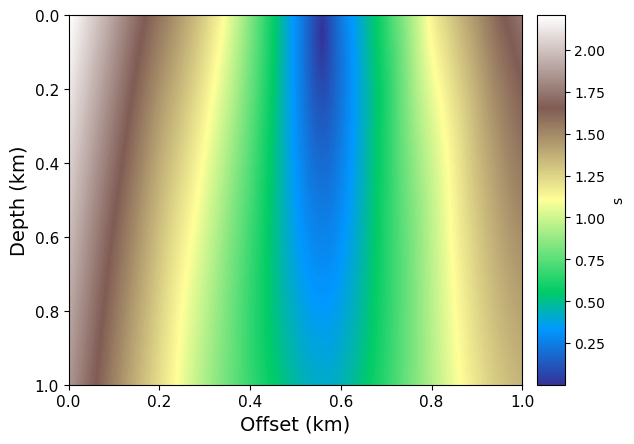

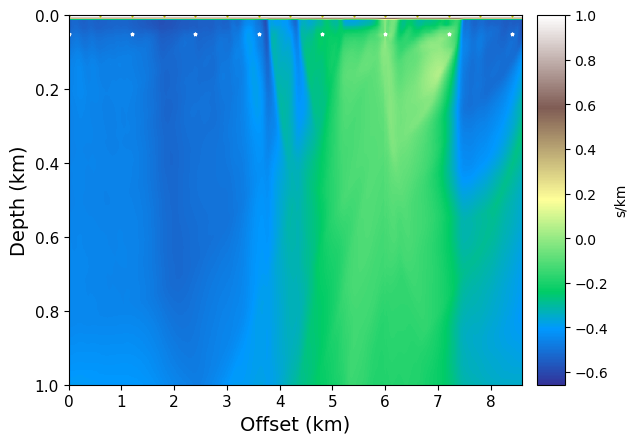

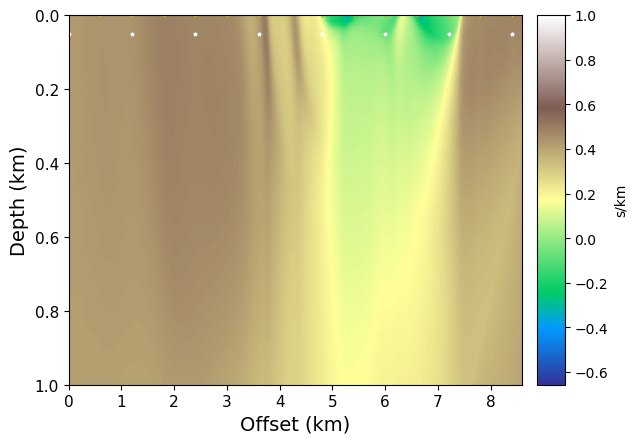

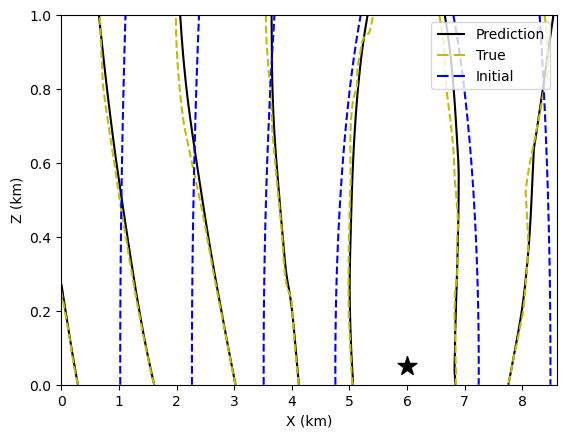

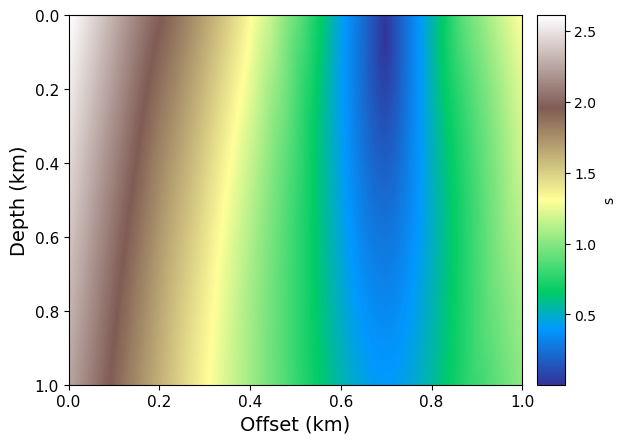

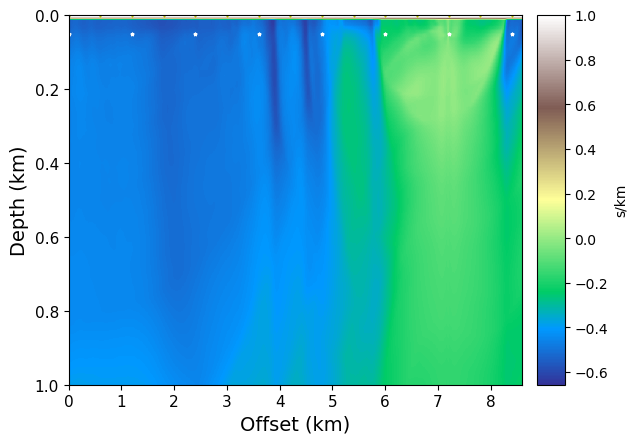

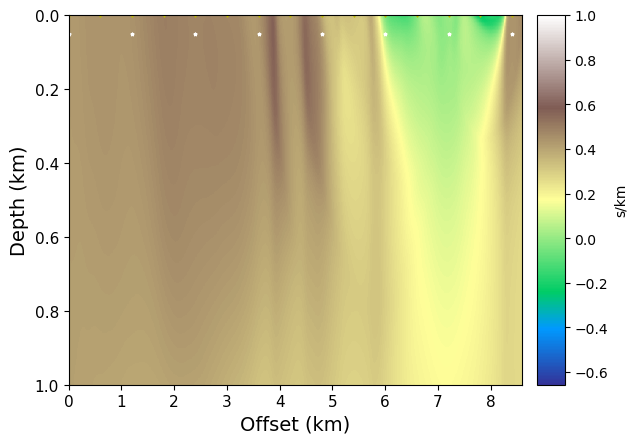

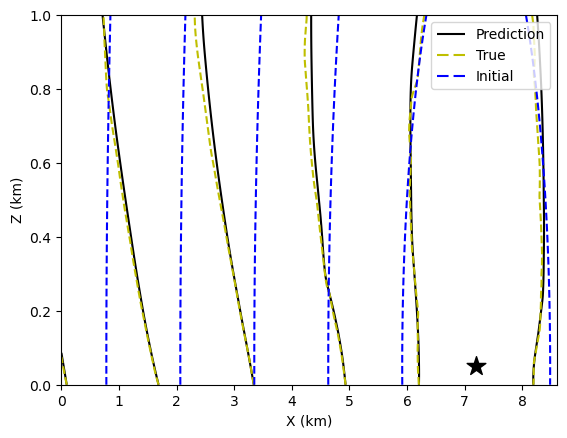

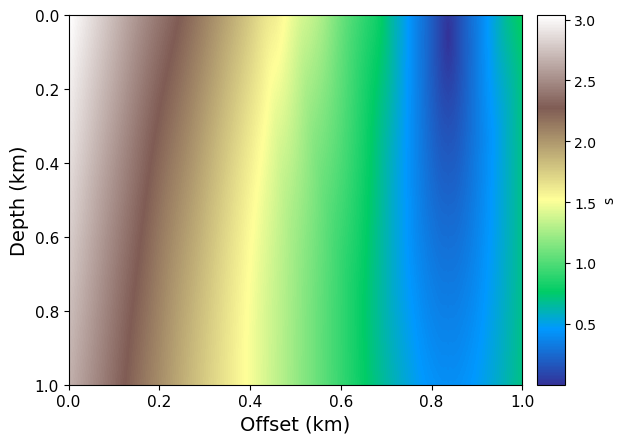

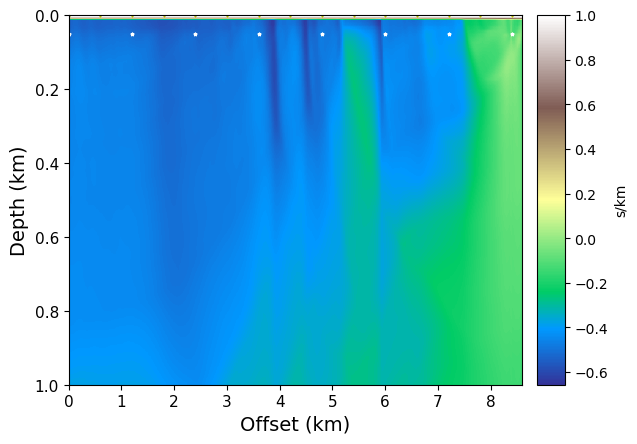

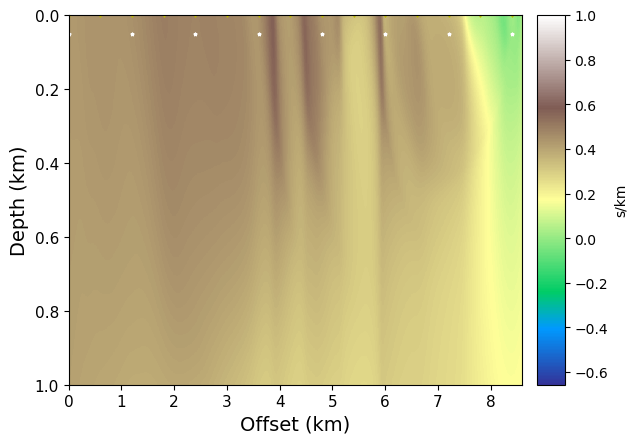

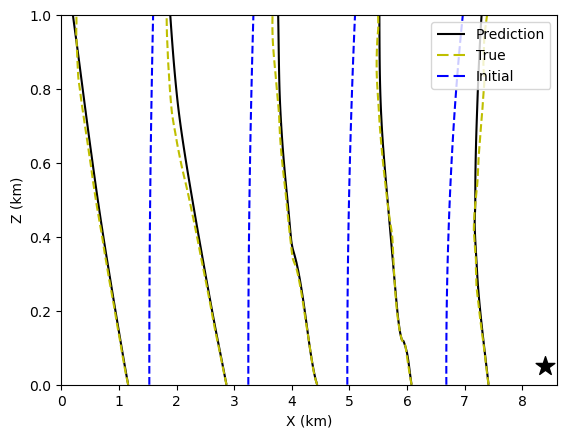

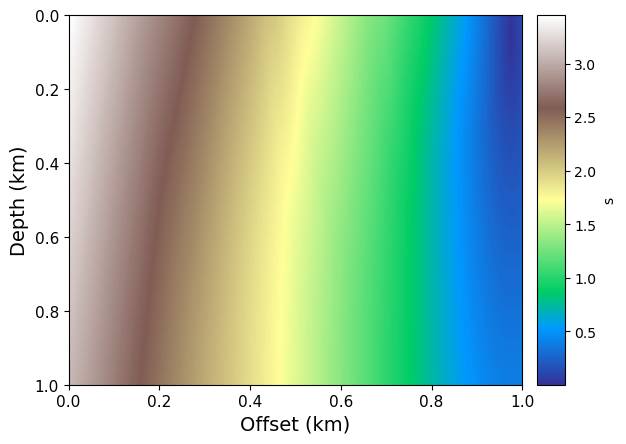

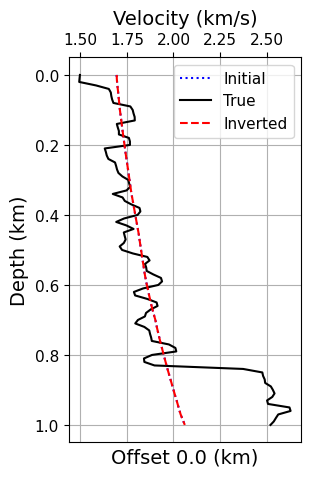

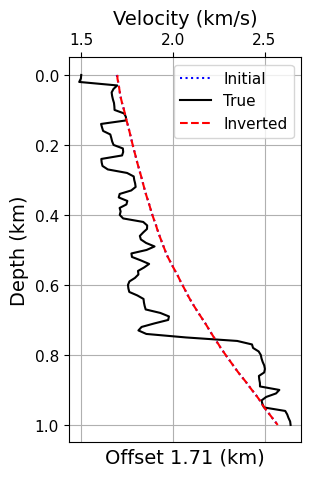

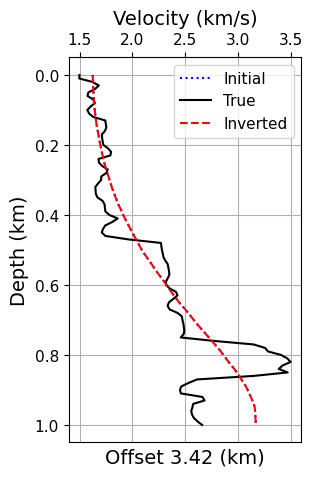

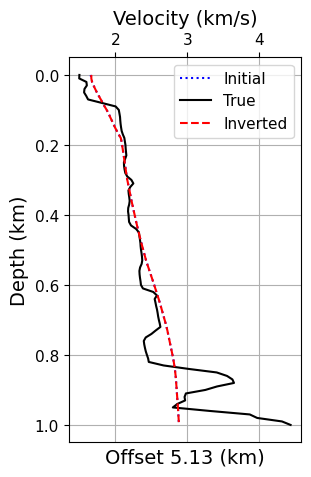

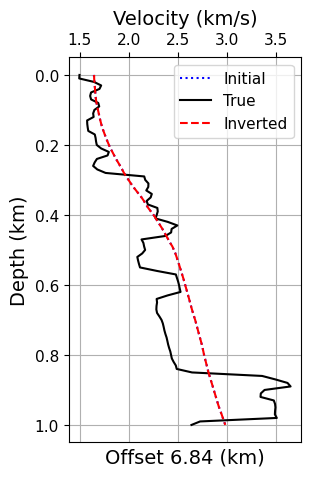

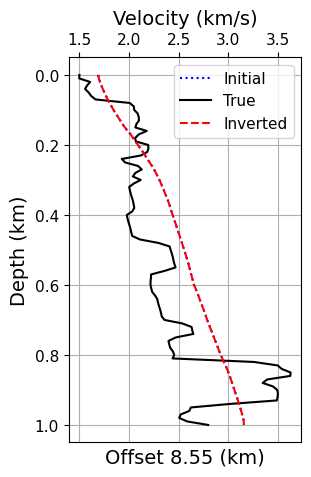

In [33]:
def plot_trace(init, true, pred, trace_id, x, z, fig_name=None, save_dir='./'):
    plt.figure(figsize=(3,5))
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

    ax = plt.gca()

    plt.plot(init[:,trace_id],z,'b:')
    plt.plot(true[:,trace_id],z,'k')
    plt.plot(pred[:,trace_id],z,'r--')

    ax.set_title('Velocity (km/s)', fontsize=14)
    
    plt.xticks(fontsize=11)
    plt.ylabel('Depth (km)', fontsize=14)
    plt.xlabel('Offset '+str(x[trace_id].round(3))+' (km)', fontsize=14)
    plt.yticks(fontsize=11)
    plt.gca().invert_yaxis()
    plt.legend(['Initial','True','Inverted'], fontsize=11)
    plt.grid()
    
    if fig_name is not None:
        plt.savefig(os.path.join(save_dir, fig_name), 
                    format='pdf', bbox_inches="tight") 
        
def plot_contour(pred, true, init, idx, nx, nz, ns, sx, sz, x, z, fig_name=None, save_dir='./', title=None):
    plt.figure()
    c_p = plt.contour(pred.reshape(nz,nx,ns)[:,:,idx],5, 
                      colors='k',extent=(x[0], x[-1], z[0], z[-1]))
    c_t = plt.contour(true.reshape(nz,nx,ns)[:,:,idx], 5, 
                      colors='y', linestyles='dashed', extent=(x[0], x[-1], z[0], z[-1]))
    c_i = plt.contour(init.reshape(nz,nx,ns)[:,:,idx], 5, 
                      colors='b', linestyles='dashed', extent=(x[0], x[-1], z[0], z[-1]))

    h1,_ = c_p.legend_elements()
    h2,_ = c_t.legend_elements()
    h3,_ = c_i.legend_elements()
    
    plt.legend([h1[0], h2[0], h3[0]], ['Prediction', 'True', 'Initial'])
    
    plt.scatter(sx[idx], sz[idx], s=200, marker='*', color='k')
    if title is not None:
        plt.title('Traveltime Contour')
    plt.xlabel('X (km)')
    plt.ylabel('Z (km)')
    plt.axis('tight')
    
    if fig_name is not None:
        plt.savefig(os.path.join(save_dir, fig_name), 
                    format='pdf', bbox_inches="tight") 


if args.rescale_plot=='y':
    earth_radi = args.plotting_factor # Average in km
    xmin, xmax, deltax = earth_radi*xmin, earth_radi*xmax, earth_radi*deltax

    if args.depth_shift=='y':
        zmin, zmax, deltaz = earth_radi*(zmin-5), earth_radi*(zmax-5), earth_radi*deltaz
    else:
        zmin, zmax, deltaz = earth_radi*(zmin-0), earth_radi*(zmax-0), earth_radi*deltaz

    # Creating grid, extending the velocity model, and prepare list of grid points for training (X_star)
    z = np.arange(zmin,zmax+deltaz,deltaz)
    x = np.arange(xmin,xmax+deltax,deltax)

    # Point-source locations
    sz = z[id_sou_z]
    sx = x[id_sou_x]

    Z,X,SX = np.meshgrid(z,x,sx,indexing='ij')

    SZ = np.ones(SX.shape)*sz # Creating an array of sources along z with same size as SX

    t_pred, T_data, T0 = t_pred*args.plotting_factor, T_data*args.plotting_factor, T0*args.plotting_factor

plot_section(v_pred, "v_pred.png", vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
plot_section(velmodel.reshape(Z.shape)[:,:,0], 'v_true.png', 
             vmin=np.nanmin(velmodel)+0.1, vmax=np.nanmax(velmodel)-0.5, 
             save_dir=wandb_dir, aspect='auto',
             xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
             sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 

plot_int = len(id_sou_x)//5 if len(id_sou_x)>=5 else 1
for i in range(0, len(id_sou_x), plot_int):
    plot_section(tau_true[:,:,i], "tau_true_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_section(-tau_pred.reshape(Z.shape)[:,:,i], "tau_pred_"+str(i)+".png", 's/km', 
                 vmin=tau_true.min(), vmax=tau_true.max(), 
                 save_dir=wandb_dir, aspect='auto',
                 xmin=xmin, xmax=xmax, zmin=zmin, zmax=zmax, 
                 sx=x[id_sou_x],sz=z[id_sou_z],rx=x[id_rec_x],rz=z[id_rec_z]) 
    plot_contour(t_pred.reshape(nz,nx,len(id_sou_x)), T_true.reshape(nz,nx,len(id_sou_x)),
                 T0.reshape(nz,nx,len(id_sou_x)), i, nx, nz, len(id_sou_x), sx, sz, x, z,
                 'contour_'+str(i)+'.png', save_dir=wandb_dir)
    plot_section(t_pred.reshape(nz,nx,len(id_sou_x))[:,:,i], 't_pred_'+str(i)+'.png', 's', 
                 save_dir=wandb_dir, aspect='auto') 

v_pred[0,:] = np.copy(v_pred[1,:])

for i in range(0, len(x), len(x)//5):
    plot_trace(v_init, v_true, v_pred, i, x, z, "v_trace_"+str(i)+".png", save_dir=wandb_dir)

# # Save model
# torch.save({
#         'tau_model_state_dict': tau_model.state_dict(),
#         'v_model_state_dict': v_model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss_history
# }, wandb_dir+'/saved_model')

# # To load
# checkpoint = torch.load(wandb_dir+'/saved_model')
# tau_model.load_state_dict(checkpoint['tau_model_state_dict'])
# v_model.load_state_dict(checkpoint['v_model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
sx

In [ ]:
v_pred.shape

In [ ]:
args.rescale_plot

In [ ]:
optimizer

In [ ]:
Z.size//200

In [ ]:
x

In [ ]:
z

In [ ]:
args.initialization